## This notebook aims to visualize the different asset distributions produced by CGAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical


In [2]:
import os
print(os.getcwd())

c:\Users\nicka\master-thesis\internal_models\CGANs


## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [3]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [4]:
asset_names = returns_df.columns

In [5]:
from internal_models.utilities.generate_quarterly_scenarios import generate_quarterly_scenarios

## TRAINING CGAN

In [6]:
from cgan2 import CGAN2
from CGAN1 import CGAN1
from cgan3 import CGAN3

for asset_name in returns_df.columns:
    print(f"Training CGAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    # Create WGAN instance for the current asset
    gan = CGAN3(asset_returns, asset_name)
    
    # Train WGAN for this asset
    gan.train()
    scenarios = gan.generate_scenarios(num_scenarios=10000)
    
    print(f"Finished training CGAN for {asset_name}.\n")

Training CGAN for REEL...
[Epoch 0/3500] [Batch 0/16] [D loss: 0.1486] [G loss: -0.5136]
[Epoch 0/3500] [Batch 10/16] [D loss: -0.1924] [G loss: -0.4953]
[Epoch 1/3500] [Batch 0/16] [D loss: 0.2398] [G loss: -0.3097]
[Epoch 1/3500] [Batch 10/16] [D loss: 0.0477] [G loss: -0.3891]
[Epoch 2/3500] [Batch 0/16] [D loss: 0.0713] [G loss: -0.1915]
[Epoch 2/3500] [Batch 10/16] [D loss: -0.1255] [G loss: -0.4538]
[Epoch 3/3500] [Batch 0/16] [D loss: -0.0178] [G loss: -0.2561]
[Epoch 3/3500] [Batch 10/16] [D loss: 0.1266] [G loss: 0.0373]
[Epoch 4/3500] [Batch 0/16] [D loss: -0.0014] [G loss: -0.1530]
[Epoch 4/3500] [Batch 10/16] [D loss: -0.2208] [G loss: -0.0739]
[Epoch 5/3500] [Batch 0/16] [D loss: -0.1073] [G loss: 0.1856]
[Epoch 5/3500] [Batch 10/16] [D loss: 0.0831] [G loss: 0.1216]
[Epoch 6/3500] [Batch 0/16] [D loss: -0.2171] [G loss: 0.1304]
[Epoch 6/3500] [Batch 10/16] [D loss: -0.0522] [G loss: 0.1481]
[Epoch 7/3500] [Batch 0/16] [D loss: 0.3082] [G loss: 0.1957]
[Epoch 7/3500] [Batc

## RESULTS

In [7]:
scenarios = gan.generate_scenarios(num_scenarios=10000)

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_REEL_final_scenarios.pt


Loaded Generated returns from: generated_CGAN_output_test\generated_returns_REEL_final_scenarios.pt
Scaled = False


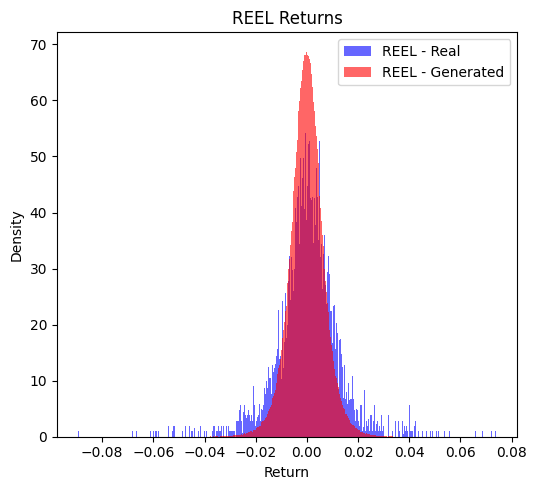


📊 Return Statistics Summary:
           Asset      Mean  Std Dev  Skewness  Kurtosis  99.5% VaR
     REEL - Real  0.000193 0.012916 -0.270455  4.969021  -0.051644
REEL - Generated -0.000097 0.006761 -0.079183  1.718959  -0.020968



═══════════════════════════
║  ANALYZING ASSET: REEL  ║
═══════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_REEL_final_scenarios.pt
Variance of Real Data: 0.000167
Variance of Generated Data: 0.000030
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.276380
Mean Pairwise Distance (Generated): 0.117563
⚠️ Warning: Potential Mode Collapse - Samples are too similar


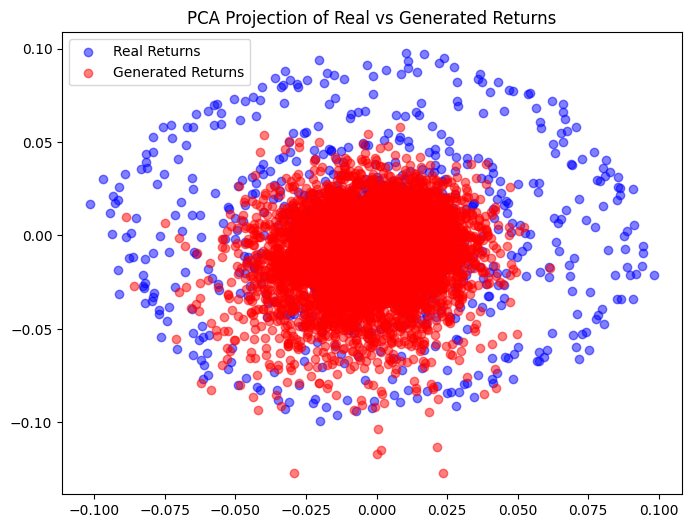

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_REEL_final_scenarios.pt


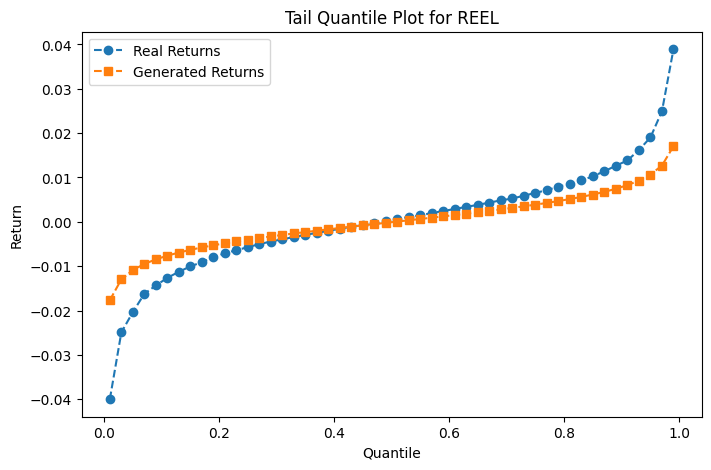


════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: REEL  ║
════════════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_REEL_final_scenarios.pt

📊 Distance Summary for REEL:
Min Distance: 0.000000
Max Distance: 2.917487
Mean Distance: 0.001464
Median Distance: 0.000348
Standard Deviation: 0.010372


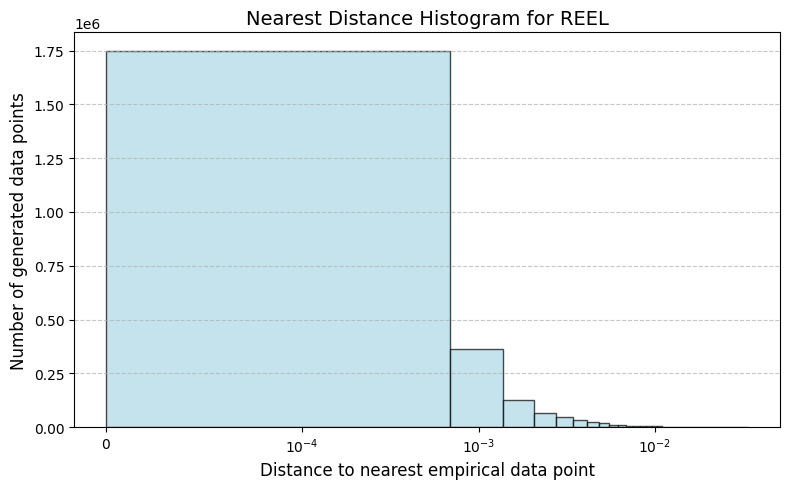


══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: REEL  ║
══════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_REEL_final_scenarios.pt
📊 Wasserstein Distance for REEL: 0.003808



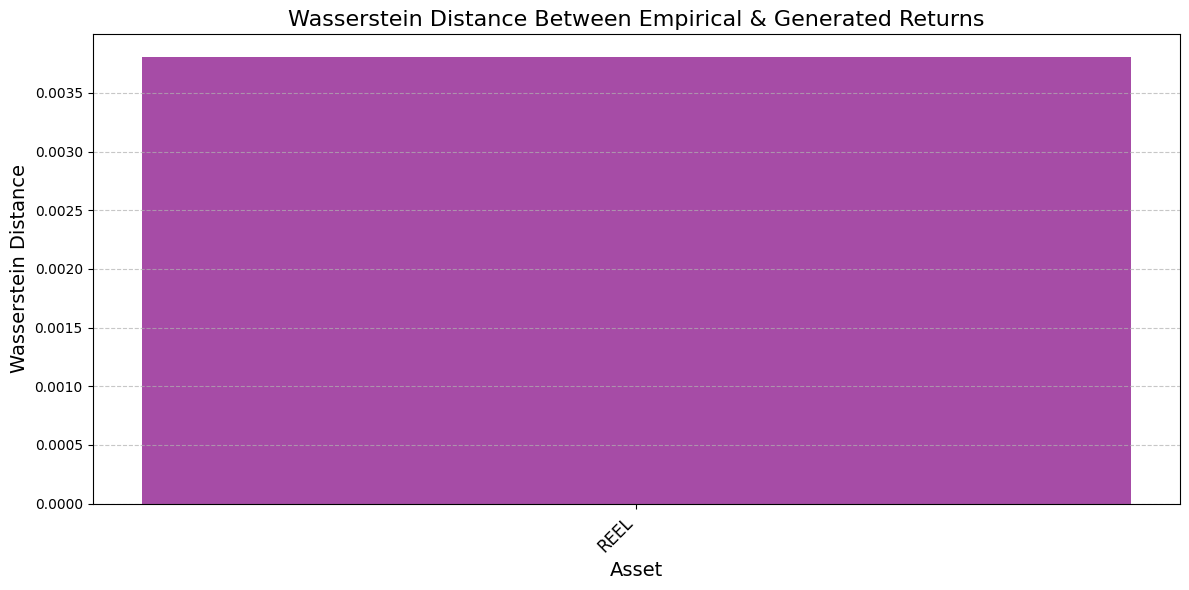

In [8]:
extensive_plotting(scaled=False, returns_df=returns_df, test=True, quarterly=False)

In [9]:
from utilities.load_generated_quarters import load_all_generated_quarters

In [10]:
for asset_name in returns_df.columns:
    # Create a new function that loads all fucking quarter for a fucking asset
    generated_returns = load_all_generated_quarters(asset_name, quarterly=True, test=True)

    failures, var_thresholds = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name, quarterly=True)

    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=var_thresholds, asset_name=asset_name, generated_returns=generated_returns)


    perform_distribution_tests(generated_returns=generated_returns[0], empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)


FileNotFoundError: [Errno 2] No such file or directory: 'generated_CGAN_output_test\\q0\\generated_returns_REEL_q0.pt'